In [ ]:
# n_participants + N_INCIDENTS_FOR_THAT_WEEK

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import mapply
mapply.init(n_workers=7, progressbar=True)

import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

# Read in the data
final = pd.read_csv('../dataset/data/final_clean3.csv')

final.columns

final.shape

final.head()




,date_year,date_month,state,incident_characteristics1,congressional_district,date_day,city_or_county,latitude,longitude,min_age_participants,...,cd_month_SHOT_DEAD,cd_month_NON_SHOOTING,cd_month_SHOTS_FIRED_UNHARMED,cd_month_OTHER,state_month_SHOT_INJURED,state_month_SHOT_DEAD,state_month_NON_SHOOTING,state_month_SHOTS_FIRED_UNHARMED,state_month_OTHER,non_workday
0,2013.0,1,CALIFORNIA,SHOT_INJURED,43.0,1,Hawthorne,33.9090,-118.3330,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,2013.0,1,COLORADO,SHOT_DEAD,6.0,5,Aurora,39.6518,-104.8020,29.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,2013.0,1,LOUISIANA,SHOT_INJURED,2.0,21,New Orleans,29.9435,-90.0836,16.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,2013.0,1,LOUISIANA,SHOT_INJURED,3.0,26,Charenton,29.8816,-91.5251,48.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,2013.0,1,MARYLAND,SHOT_INJURED,7.0,23,Baltimore,39.2899,-76.6412,15.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [5]:
#filter only for accidents  between 2014 and 2017
final_wout_wrng_years = final[(final['date_year'] >= 2014) & (final['date_year'] <= 2017)].copy()


## Dataframe with only the correct years for timeseries
final_wout_wrng_years.shape

final_wout_wrng_years.columns

# make a new column with the week number from timestamp//7 - number of weeks from 2010-01-01

final_wout_wrng_years['week_number'] = (final_wout_wrng_years['timestamp']//7) - 208

final_wout_wrng_years['week_number'] = final_wout_wrng_years['week_number'].astype(int)

In [4]:
#sort by week using date_year, date_month, date_day
city_df = final_wout_wrng_years.sort_values(by=['week_number']).copy()
city_df

#boston = city_df[city_df['city_or_county'] == 'Boston'].copy()



#create a new dataframe with 3 colums: week_number, city, number of accidents per week

cool_df = city_df.groupby(['week_number', 'city_or_county']).size().reset_index(name='counts')
#cool_df

#pivot the table to have the cities as columns
pivot_df = cool_df.pivot(index='week_number', columns='city_or_county', values='counts')
#pivot_df

#fill the NaN values with 0
pivot_df = pivot_df.fillna(0)
pivot_df

#make them integers
pivot_df = pivot_df.astype(int)
pivot_df


city_or_county,Abbeville,Abbotsford,Abbott,Abbott Township,Abbottstown,Abercrombie,Aberdeen,Abilene,Abingdon,Abington,...,Zion,Zion (Beach Park),Zion Grove,Zionsville,Zionville,Zumbro Falls,Zumbrota,Zuni (Zuni Pueblo),Zwolle,jefferson parish (county)
week_number,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#remove the colums with less than 15% of 208 weeks
pivot_df = pivot_df.loc[:, (pivot_df.sum(axis=0) > 30)]
pivot_df

#give me the list of cities remaining
pivot_df.columns



final_pivot = pivot_df.copy()

#remove from city_df the cities that are not in the pivot_df
clean_city_df = city_df[city_df['city_or_county'].isin(final_pivot.columns)].copy()




,date_year,date_month,state,incident_characteristics1,congressional_district,date_day,city_or_county,latitude,longitude,min_age_participants,...,cd_month_NON_SHOOTING,cd_month_SHOTS_FIRED_UNHARMED,cd_month_OTHER,state_month_SHOT_INJURED,state_month_SHOT_DEAD,state_month_NON_SHOOTING,state_month_SHOTS_FIRED_UNHARMED,state_month_OTHER,non_workday,week_number
936,2014.0,1,FLORIDA,SHOT_INJURED,9.0,2,Orlando,28.4360,-81.3928,20.0,...,0.117647,0.176471,0.235294,0.377119,0.173729,0.029661,0.076271,0.34322,0,0
2846,2014.0,1,PENNSYLVANIA,SHOT_INJURED,13.0,1,Philadelphia,40.0331,-75.1069,34.0,...,0.000000,0.000000,0.166667,0.445055,0.252747,0.027473,0.054945,0.21978,1,0
940,2014.0,1,FLORIDA,SHOT_INJURED,10.0,1,Orlando,28.4532,-81.3890,18.0,...,0.000000,0.000000,0.500000,0.377119,0.173729,0.029661,0.076271,0.34322,1,0
945,2014.0,1,FLORIDA,SHOT_INJURED,14.0,2,Saint Petersburg,27.7673,-82.6907,24.0,...,0.000000,0.120000,0.520000,0.377119,0.173729,0.029661,0.076271,0.34322,0,0
947,2014.0,1,FLORIDA,SHOT_INJURED,14.0,1,Tampa,27.9447,-82.4842,27.0,...,0.000000,0.120000,0.520000,0.377119,0.173729,0.029661,0.076271,0.34322,1,0


In [7]:
clean_city_df.groupby(['city_or_county'])["n_killed"].sum().sort_values(ascending=True)


city_or_county
Oil City (Caddo)       1.0
Meriden                1.0
Janesville             2.0
Fulton                 2.0
Framingham             2.0
                     ...  
Philadelphia         877.0
Saint Louis          904.0
Baltimore           1042.0
Houston             1169.0
Chicago             2093.0
Name: n_killed, Length: 790, dtype: float64

In [124]:
TO_RENAME = clean_city_df.copy()


incidents_city_week = TO_RENAME.groupby(['week_number', 'city_or_county']).size()
#incidents_city_week

n_participants_city_week = TO_RENAME.groupby(['week_number', 'city_or_county'])['n_participants'].sum()


TO_RENAME = TO_RENAME.set_index(['week_number','city_or_county'])


def score(df: pd.DataFrame):
    return incidents_city_week.loc[df.name] + n_participants_city_week.loc[df.name]

# TO_RENAME['score'] = TO_RENAME.groupby(TO_RENAME.index.names).apply(score)
TO_RENAME['score'] = TO_RENAME.groupby(TO_RENAME.index.names)['n_killed'].sum()
TO_RENAME['label'] = TO_RENAME.groupby(TO_RENAME.index.names)['n_killed'].sum().apply(lambda x: 1 if x > 0 else 0).astype(int)



score_pivot = TO_RENAME.pivot_table(index='week_number', columns='city_or_county', values='score')
score_pivot = score_pivot.fillna(0)

label_pivot = TO_RENAME.pivot_table(index='week_number', columns='city_or_county', values='label')
label_pivot = label_pivot.fillna(0)


In [125]:
# We keep this for historical reasons (PC+4)
threshold = 1

city_label = label_pivot.sum(axis=0) 
city_label.sort_values(ascending=False).median()

city_label = city_label > city_label.median() - 1

city_label.value_counts()

True     397
False    393
Name: count, dtype: int64

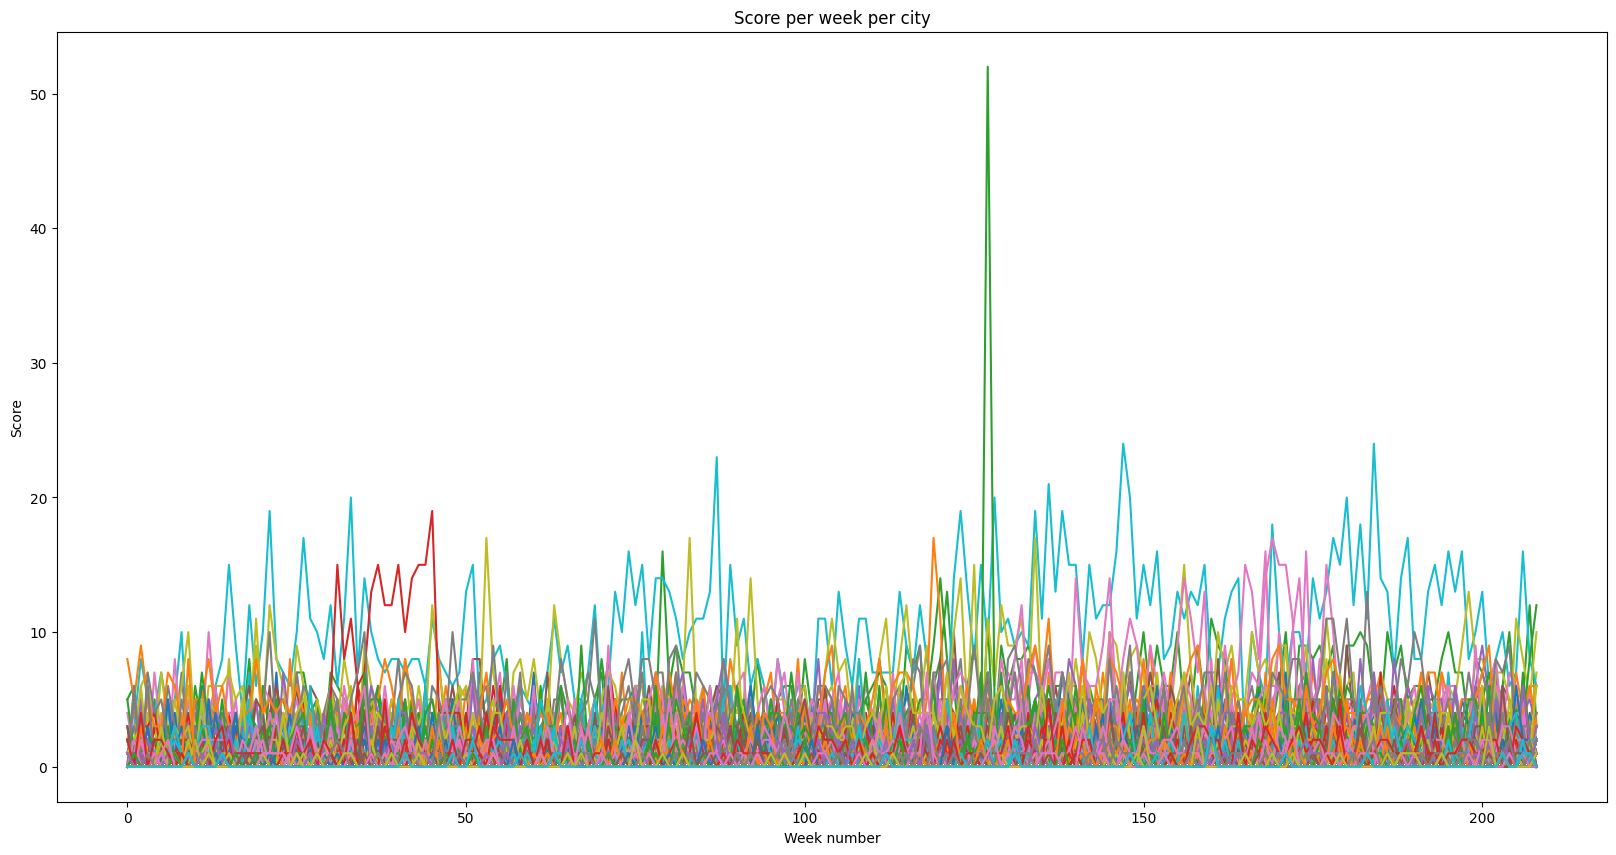

In [126]:

score_pivot.plot(figsize=(20,10), legend=False)
plt.title('Score per week per city')
plt.xlabel('Week number')
plt.ylabel('Score')
plt.show()




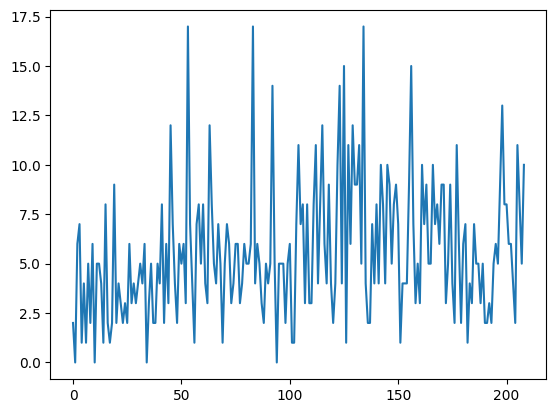

In [127]:
ts1 = pd.Series(score_pivot['Houston'])
plt.plot(ts1)
plt.show()

---

In [149]:
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

X = score_pivot.values.T
y = city_label.values

from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

scaler_1 = TimeSeriesScalerMeanVariance(0, 1)

# X = scaler_1.fit_transform(X)[:,:,0]

X = X.cumsum(axis=1)

X = X / X.max()
# scaler_2 = TimeSeriesScalerMinMax((-1, 1))

# X = scaler_2.fit_transform(X)[:,:,0]

# Compute number and length of shapelets.
# l: Fraction of the length of time series to be used for base shapelet length
# r: Number of different shapelet lengths to use

# return: Dictionary giving, for each shapelet length, the number of such shapelets to be generated


n_ts, ts_sz = X.shape
n_classes = len(set(y))


shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=2)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 790
ts_sz 209
n_classes 2
shapelet_sizes {20: 5, 40: 5}


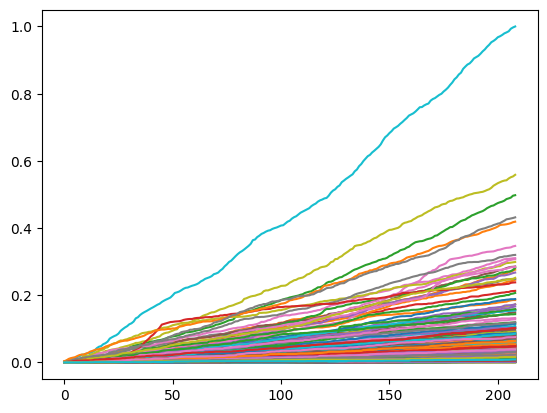

In [157]:
plt.plot(X[:].T)

In [151]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=100,
                        verbose=1,
                        scale=False)

shp_clf.fit(X, y)

/home/stefano/Desktop/Big Data Unipi/DM/Project/DataMining-2023/.env9/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/100
4/4 [==============================] - 1s 16ms/step - loss: 0.7025 - binary_accuracy: 0.5025 - binary_crossentropy: 0.6887
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7024 - binary_accuracy: 0.5051 - binary_crossentropy: 0.6886
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7024 - binary_accuracy: 0.5063 - binary_crossentropy: 0.6885
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7023 - binary_accuracy: 0.5101 - binary_crossentropy: 0.6884
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7022 - binary_accuracy: 0.5127 - binary_crossentropy: 0.6884
Epoch 6/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7021 - binary_accuracy: 0.5152 - binary_crossentropy: 0.6883
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 0.7020 - binary_accuracy: 0.5165 - binary_crossentropy: 0.6883
Epoch 8/100
4/4 [==============================] - 0s 2

LearningShapelets(max_iter=100, n_shapelets_per_size={20: 5, 40: 5}, verbose=1,
                  weight_regularizer=0.01)

In [152]:
from sklearn.metrics import accuracy_score
predicted_labels = shp_clf.predict(X)
print("Correct classification rate:", accuracy_score(y, predicted_labels))
predicted_locations = shp_clf.locate(X)

4/4 [==============================] - 0s 9ms/step
Correct classification rate: 0.5987341772151898
4/4 [==============================] - 0s 9ms/step


True


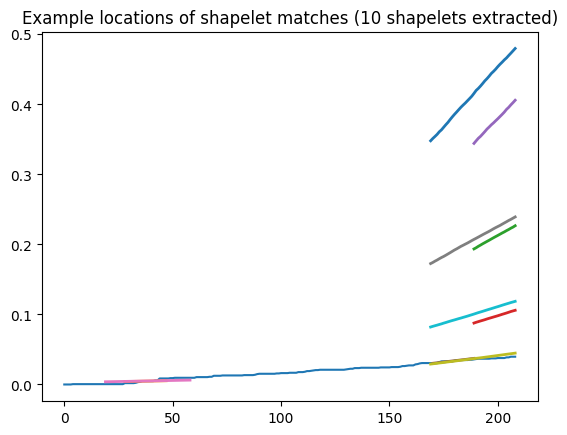

In [156]:
ts_id = 609
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title(f"""Example locations of shapelet matches ({n_shapelets} shapelets extracted)""")

plt.plot(X[ts_id])
# plt.plot(X[ts_id].ravel())
print(y[ts_id])
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

In [98]:
shp_clf.__dict__

{'n_shapelets_per_size': {20: 5, 40: 5, 60: 5, 80: 5, 100: 4},
 'max_iter': 100,
 'batch_size': 256,
 'verbose': 1,
 'optimizer': 'sgd',
 'weight_regularizer': 0.01,
 'shapelet_length': 0.15,
 'total_lengths': 3,
 'max_size': None,
 'scale': True,
 'random_state': None,
 '_min_sz_fit': 209,
 '_X_fit_dims': (790, 209, 1),
 'model_': <keras.src.engine.functional.Functional at 0x7f9b3557e910>,
 'transformer_model_': <keras.src.engine.functional.Functional at 0x7f9b35648160>,
 'locator_model_': <keras.src.engine.functional.Functional at 0x7f9b35594d00>,
 'd_': 1,
 'classes_': array([False,  True]),
 'label_to_ind_': {False: 0, True: 1},
 'n_shapelets_per_size_': {20: 5, 40: 5, 60: 5, 80: 5, 100: 4},
 'history_': {'loss': [0.7085477113723755,
   0.708509087562561,
   0.7084811329841614,
   0.7084481120109558,
   0.708432137966156,
   0.7083738446235657,
   0.7083450555801392,
   0.7082939743995667,
   0.7082383036613464,
   0.7081956267356873,
   0.7081626653671265,
   0.7081319093704224,
 

#  Another method for the Shaplet

In [159]:
from pyts.transformation import ShapeletTransform
st = ShapeletTransform(n_shapelets=5, window_sizes=[8])
st.fit(X, y)

KeyboardInterrupt: 

In [ ]:
len(st.shapelets_)

In [ ]:
st.shapelets_

In [ ]:
for s in st.shapelets_:
    plt.plot(s)

plt.show()

In [ ]:
from pyts.classification import LearningShapelets
shp_clf = LearningShapelets(random_state=42, tol=0.01)

In [ ]:
shp_clf.fit(X, y)

In [ ]:
shp_clf.coef_.shape

In [ ]:
# Select three shapelets
sel_shapelets = np.asarray([shp_clf.shapelets_[0, 0], 
                        shp_clf.shapelets_[0, 1], 
                        shp_clf.shapelets_[0, 2]])

In [ ]:
plt.plot(sel_shapelets[0])
plt.plot(sel_shapelets[1])
plt.plot(sel_shapelets[2])

plt.show()